<a href="https://colab.research.google.com/github/KvindtEva/Time-Machine-Marburg/blob/main/DataSetEntityClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

lets see if the file is uploaded

In [1]:
ls

sample_data/


In [40]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans #traditional k-means
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

defining the path

In [7]:
path_dataset_Clean = "/content/drive/MyDrive/time_machine_project/dataset_CLEAN.csv"

In [8]:
import pandas as pd
import numpy as np


In [9]:
df = pd.read_csv(path_dataset_Clean, sep=";")
type(df)

pandas.core.frame.DataFrame

In [10]:
df.head(3)

,id_record,id_persistent,label,image_links,archive_links,microfiche_links,microfiche_archive_links
0,http://www.bildindex.de/document/obj20666124,http://id.bildindex.de/thing/0001618283,"Lauenhain (Kreis Hainichen), Fahnenträger eine...",[],[],['http://www.bildindex.de/bilder/d/mi12308g07'],['https://www.bildindex.de/media/obj20666124/m...
1,http://www.bildindex.de/document/obj20727600,http://id.bildindex.de/thing/0001677732,Fenster (Bauelement),['http://www.bildindex.de/bilder/d/fm140030'],['https://www.bildindex.de/media/obj20727600/f...,['http://www.bildindex.de/bilder/d/mi02117a05'...,['https://www.bildindex.de/media/obj20727600/m...
2,http://www.bildindex.de/document/obj20943303,http://id.bildindex.de/thing/0001803584,"Kassel, Infanteriekasernen an der Königsstraße...",['http://www.bildindex.de/bilder/d/STMP_II_110...,['https://www.bildindex.de/media/obj20943303/S...,[],[]


here i would like to make a matrix which contains just the lables of our dataset

In [12]:
labels_matrix = pd.DataFrame(df['label']) # i just wanted to save the lables matrix as a Datafram otherwise it will be saved as a Series!
type(labels_matrix)

pandas.core.frame.DataFrame

In [13]:
labels_matrix

,label
0,"Lauenhain (Kreis Hainichen), Fahnenträger eine..."
1,Fenster (Bauelement)
2,"Kassel, Infanteriekasernen an der Königsstraße..."
3,"Waldeck, Domäne, Wohnhaus, Umbauentwurf, Aufrisse"
4,"Kassel, Opernhaus (Altes Hoftheater), Aborte i..."
...,...
38195,"Feuerwehr, Fuhrwerk"
38196,WohnhausWerkstatt
38197,"Kassel-Wilhelmshöhe, Hofgärtnerhaus, Bauaufnah..."
38198,Landgrafenschloss


# Encoding the lables using LabelEncoder()

In [15]:
label_encoder = LabelEncoder()
labels_matrix['label_encoded'] = label_encoder.fit_transform(labels_matrix['label'])

In [16]:
labels_matrix

,label,label_encoded
0,"Lauenhain (Kreis Hainichen), Fahnenträger eine...",16315
1,Fenster (Bauelement),7746
2,"Kassel, Infanteriekasernen an der Königsstraße...",13737
3,"Waldeck, Domäne, Wohnhaus, Umbauentwurf, Aufrisse",26866
4,"Kassel, Opernhaus (Altes Hoftheater), Aborte i...",14168
...,...,...
38195,"Feuerwehr, Fuhrwerk",7916
38196,WohnhausWerkstatt,27993
38197,"Kassel-Wilhelmshöhe, Hofgärtnerhaus, Bauaufnah...",14704
38198,Landgrafenschloss,15900


ok, until here i encoded the lables column with LabelEncoder() method which just hashes the texts to a number, i guss this encoder really encodes the lables to some nonsence numbers which are not useful for Language Processing and text clustering, but, lets just see:

# K-means Clustering with label_encoded column **(not successful at all)**

In [17]:
n_clusters = len(labels_matrix['label'].unique())  # Let's assume we want as many clusters as unique labels
#kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#labels_matrix['cluster'] = kmeans.fit_predict(labels_matrix[['label_encoded']])

In [18]:
n_clusters

29102

it took more than 17 minutes so i got bored! lets try transfer everything to GPU

In [19]:
import torch

In [24]:
# Check if GPU is available and use it if possible/
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
# making a torch tensor with float 32
data_GPU_suitable = torch.tensor(labels_matrix['label_encoded'].values, dtype = torch.float32).unsqueeze(1).to(device
                                                                                                               )

In [33]:
n_clusters_GPU_try = n_clusters
data_size = data_GPU_suitable.size(0)
data_size

38200

In [34]:
centroids = data_GPU_suitable[torch.randperm(data_size)[:n_clusters_GPU_try]].to(device)
centroids

tensor([[ 1695.],
        [29039.],
        [19077.],
        ...,
        [13805.],
        [14281.],
        [14180.]], device='cuda:0')

In [35]:
def compute_distance(a, b):
    return torch.sqrt(torch.sum((a - b) ** 2, dim=1))

In [36]:
iteration_for_kmeans = 100

In [37]:
# K-Means iteration
for iteration in range(iteration_for_kmeans):

  # Step 1: Assign clusters
  distances = torch.stack([compute_distance(data_GPU_suitable, centroid) for centroid in centroids])
  cluster_assignments = torch.argmin(distances, dim=0)

  # Step 2: Update centroids
  new_centroids = torch.stack([data_GPU_suitable[cluster_assignments == i].mean(dim=0) for i in range(n_clusters)])

  # Check for convergence (centroids don't change)
  if torch.allclose(centroids, new_centroids, atol=1e-6):
    break

  centroids = new_centroids

In [38]:
# Attach the cluster assignments back to the dataframe
labels_matrix['cluster'] = cluster_assignments.cpu().numpy()

In [39]:
labels_matrix

,label,label_encoded,cluster
0,"Lauenhain (Kreis Hainichen), Fahnenträger eine...",16315,1
1,Fenster (Bauelement),7746,1
2,"Kassel, Infanteriekasernen an der Königsstraße...",13737,1
3,"Waldeck, Domäne, Wohnhaus, Umbauentwurf, Aufrisse",26866,1
4,"Kassel, Opernhaus (Altes Hoftheater), Aborte i...",14168,1
...,...,...,...
38195,"Feuerwehr, Fuhrwerk",7916,1
38196,WohnhausWerkstatt,27993,1
38197,"Kassel-Wilhelmshöhe, Hofgärtnerhaus, Bauaufnah...",14704,1
38198,Landgrafenschloss,15900,1


## Visualize the torch tensor K-means:

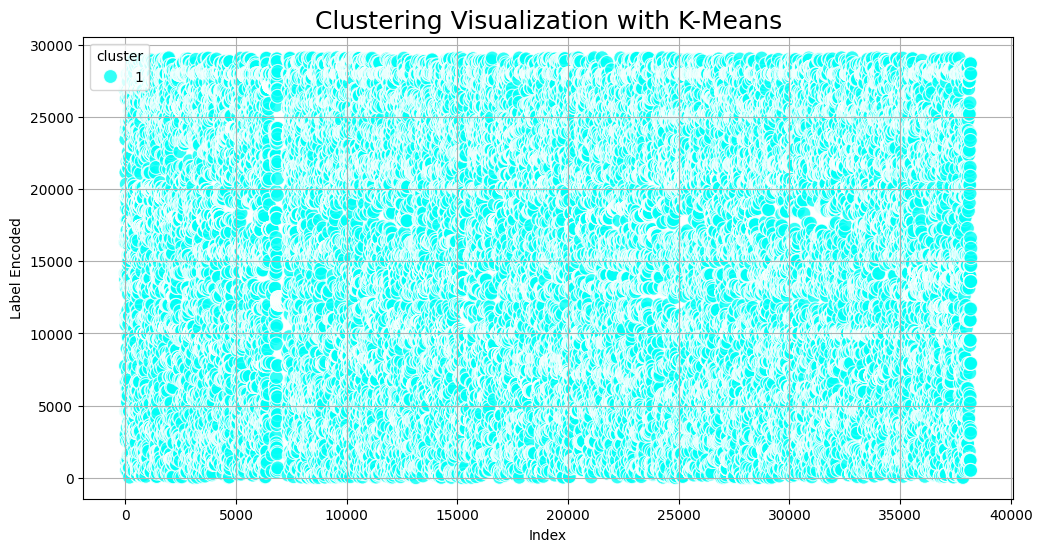

In [42]:
plt.figure(figsize=(12, 6))

sns.scatterplot(
    x=df.index, y=labels_matrix['label_encoded'],
    hue=labels_matrix['cluster'],
    palette=sns.color_palette("hsv", len(labels_matrix['cluster'].unique())),
    legend="full",
    s=100,
    alpha=0.8
)

plt.title('Clustering Visualization with K-Means', fontsize=18)
plt.xlabel('Index')
plt.ylabel('Label Encoded')
plt.grid(True)
plt.show()

In [44]:
num_clusters =labels_matrix['cluster'].nunique()
num_clusters

1

# Terms Document Matrix Creation

In [62]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer #unusful but lets import it maybe we need it in future
from nltk.stem import SnowballStemmer #for german text
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.data import find

In [57]:
# Download NLTK data (if not already done)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

below i just want to make sure if we have both punkt and stopwords from nltk.

In [58]:
# Initialize NLTK tools
stop_words = set(stopwords.words('german'))
stemmer = SnowballStemmer('german')

In [59]:
# Define a function for preprocessing text
def preprocess_text(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text.lower())

    # Remove stopwords and apply stemming
    tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word not in stop_words]

    # Join tokens back into a single string
    return ' '.join(tokens)

In [60]:
# Apply preprocessing to the labels
labels_matrix['processed_label'] = labels_matrix['label'].apply(preprocess_text)

In [61]:
labels_matrix

,label,label_encoded,cluster,processed_label
0,"Lauenhain (Kreis Hainichen), Fahnenträger eine...",16315,1,lauenhain kreis hainich fahnentrag internation...
1,Fenster (Bauelement),7746,1,fenst bauelement
2,"Kassel, Infanteriekasernen an der Königsstraße...",13737,1,kassel infanteriekasern konigsstrass bestandsa...
3,"Waldeck, Domäne, Wohnhaus, Umbauentwurf, Aufrisse",26866,1,waldeck doman wohnhaus umbauentwurf aufriss
4,"Kassel, Opernhaus (Altes Hoftheater), Aborte i...",14168,1,kassel opernhaus alt hoftheat abort flugelgeba...
...,...,...,...,...
38195,"Feuerwehr, Fuhrwerk",7916,1,feuerwehr fuhrwerk
38196,WohnhausWerkstatt,27993,1,wohnhauswerkstatt
38197,"Kassel-Wilhelmshöhe, Hofgärtnerhaus, Bauaufnah...",14704,1,hofgartnerhaus bauaufnahm grundriss
38198,Landgrafenschloss,15900,1,landgrafenschloss


In [63]:
# Convert the processed text data into TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(labels_matrix['processed_label'])
tfidf_matrix

<38200x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 115516 stored elements in Compressed Sparse Row format>

In [71]:
# Store the TF-IDF vectors as a list of values in a new column
labels_matrix['tfidf_vector'] = list(tfidf_matrix.toarray())
labels_matrix.head(3)

,label,label_encoded,cluster,processed_label,tfidf_vector
0,"Lauenhain (Kreis Hainichen), Fahnenträger eine...",16315,1,lauenhain kreis hainich fahnentrag internation...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Fenster (Bauelement),7746,1,fenst bauelement,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"Kassel, Infanteriekasernen an der Königsstraße...",13737,1,kassel infanteriekasern konigsstrass bestandsa...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [72]:
#convert the tfidf matrix to a 2 mode tensor in pytorch
tfidf_tensor = torch.tensor(tfidf_matrix.toarray(), dtype=torch.float32)

In [73]:
# Determine the device to use (GPU if available)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use this line if you did not defined device before in the non successful part above
tfidf_tensor = tfidf_tensor.to(device)